<a href="https://colab.research.google.com/github/AtfastrSlushyMaker/pl-standings-prediction-project/blob/main/notebooks/algorithms/SVM/svm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Defining Relegation Target and Train/Test Split


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

## Load and Inspect Dataset



✅ Dataset loaded from: team_season_aggregated.csv

🔍 Dataset Shape: (500, 35)
📅 Seasons Available: ['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24', '2024-25']

📌 First rows preview:


,Season,Season_encoded,Team,Matches_Played,Home_Matches,Away_Matches,Wins,Draws,Losses,Home_Wins,...,Yellow_Cards,Red_Cards,Fouls,Corners,Avg_Corners,Win_Rate,Home_Win_Rate,Away_Win_Rate,Final_Position,Team_encoded
0,2000-01,0,Man United,38,19,19,24,8,6,15,...,44.0,3.0,433.0,269.0,7.078947,0.631579,0.789474,0.473684,1,27
1,2000-01,0,Arsenal,38,19,19,20,10,8,15,...,48.0,3.0,495.0,295.0,7.763158,0.526316,0.789474,0.263158,2,0
2,2000-01,0,Liverpool,38,19,19,20,9,9,13,...,50.0,4.0,473.0,243.0,6.394737,0.526316,0.684211,0.368421,3,24
3,2000-01,0,Leeds,38,19,19,20,8,10,11,...,72.0,3.0,589.0,270.0,7.105263,0.526316,0.578947,0.473684,4,22
4,2000-01,0,Ipswich,38,19,19,20,6,12,11,...,31.0,2.0,414.0,206.0,5.421053,0.526316,0.578947,0.473684,5,21


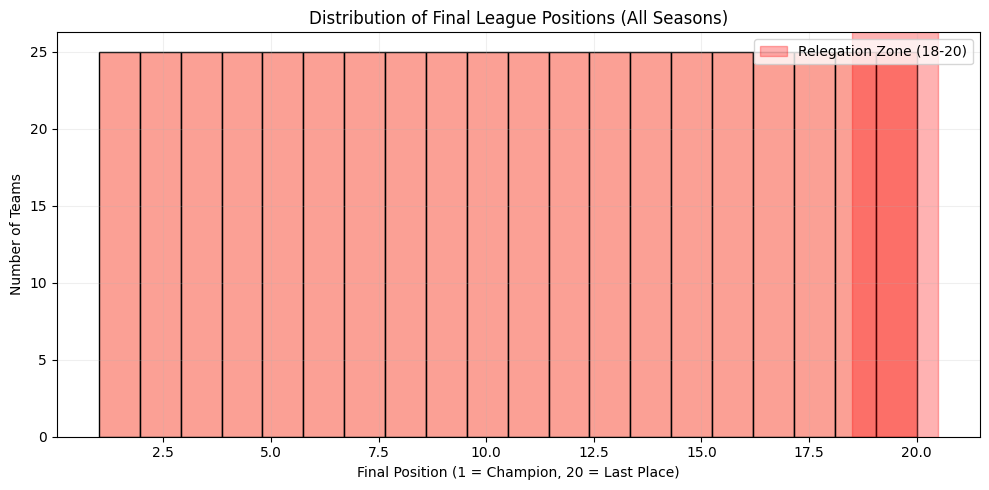


📉 Relegation Rate Across Dataset: 15.00% of teams finished in bottom 3


In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Try to load the dataset from multiple fallback locations
dataset_paths = [
    Path('team_season_aggregated.csv'),
    Path('/content/team_season_aggregated.csv'),
    Path('/mnt/data/team_season_aggregated.csv'),
    Path('data/team_season_aggregated.csv')
]

for path in dataset_paths:
    try:
        df_agg = pd.read_csv(path)
        print(f"✅ Dataset loaded from: {path}")
        break
    except FileNotFoundError:
        continue
else:
    raise FileNotFoundError("❌ team_season_aggregated.csv not found in any predefined paths.")

# 🕵️‍♂️ Inspect dataset dimensions and basic metadata
print(f"\n🔍 Dataset Shape: {df_agg.shape}")
print(f"📅 Seasons Available: {sorted(df_agg['Season'].unique()) if 'Season' in df_agg.columns else 'Not available'}")
print("\n📌 First rows preview:")
display(df_agg.head())

# 📉 Visualize distribution of Final Position for Relegation Risk
if 'Final_Position' in df_agg.columns:
    plt.figure(figsize=(10, 5))
    sns.histplot(df_agg['Final_Position'], bins=20, kde=False, color='salmon')
    plt.axvspan(18.5, 20.5, color='red', alpha=0.3, label='Relegation Zone (18-20)')
    plt.title("Distribution of Final League Positions (All Seasons)")
    plt.xlabel("Final Position (1 = Champion, 20 = Last Place)")
    plt.ylabel("Number of Teams")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

    relegation_rate = (df_agg['Final_Position'] >= 18).mean() * 100
    print(f"\n📉 Relegation Rate Across Dataset: {relegation_rate:.2f}% of teams finished in bottom 3")
else:
    print("⚠️ 'Final_Position' column not found in dataset.")


## Train-Test Split
Relegation-Aware Feature and Target Preparation for SVM



In [9]:
# ✅ Define predictive features (focused on end-of-season performance)
feature_cols = [
    'Points_Per_Game', 'Win_Rate', 'Goal_Difference',
    'Goals_Scored', 'Goals_Conceded',
    'Clean_Sheets', 'Shot_Accuracy',
    'Home_Win_Rate', 'Away_Win_Rate',
    'Yellow_Cards', 'Red_Cards',
    'Season_encoded', 'Team_encoded'
]

# 🔍 Confirm features exist in the dataset
available_features = [col for col in feature_cols if col in df_agg.columns]
missing_features = [col for col in feature_cols if col not in df_agg.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
else:
    print(f"✅ {len(available_features)} features validated for SVM.")

# 🎯 Target: Final league position (will later be categorized for relegation focus)
target_col = 'Final_Position'

# ⏳ Hold out latest season (2024-25) for evaluation
train_seasons = df_agg[df_agg['Season'] != '2024-25']
test_season  = df_agg[df_agg['Season'] ==  '2024-25']

# ✅ Split features and targets
X_train = train_seasons[available_features].copy()
y_train = train_seasons[target_col].copy()

X_test  = test_season[available_features].copy()
y_test  = test_season[target_col].copy()

# 📈 Print summary
print("\n📊 Relegation-Oriented Split Completed")
print(f"Training Set: {X_train.shape} | Test Set: {X_test.shape}")


✅ 13 features validated for SVM.

📊 Relegation-Oriented Split Completed
Training Set: (480, 13) | Test Set: (20, 13)


## SVM Regression — Base Model Training and Evaluation



In [ ]:
# Train a Support Vector Regressor (SVR) with fixed hyperparameters.
# Evaluate on training and test sets using MAE, RMSE, and R².

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 📈 Create pipeline: StandardScaler + SVR
svm_pipeline = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=10, epsilon=0.2)
)

# 🚀 Train the model
svm_pipeline.fit(X_train, y_train)

# 🔍 Predict
y_pred_train = svm_pipeline.predict(X_train)
y_pred_test = svm_pipeline.predict(X_test)

# 📊 Evaluate
def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{label} MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.4f}")

print("\n📈 Performance Summary:")
evaluate(y_train, y_pred_train, label="Train")
evaluate(y_test, y_pred_test, label="Test")



📈 Performance Summary:
Train MAE: 0.127 | RMSE: 0.149 | R²: 0.8261
Test MAE: 0.122 | RMSE: 0.142 | R²: 0.8426


## SVM Regressor Hyperparameter Tuning for Relegation Risk



In [16]:
# ⚡ Efficient Grid Search for SVM (Balanced Version)
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, ParameterGrid
import numpy as np
import time

# 🧲 Weight relegation zone more heavily (positions 18–20)
weights = np.where(y_train >= 18, 2.0, 1.0)

# 🔧 Reduced grid: still explores kernel types but fewer values
efficient_param_grid = [
    {'kernel': ['linear'], 'C': [1, 10], 'epsilon': [0.1, 0.2]},
    {'kernel': ['rbf'], 'C': [1, 10], 'gamma': ['scale'], 'epsilon': [0.1, 0.2]},
    {'kernel': ['poly'], 'C': [1], 'degree': [2, 3], 'gamma': ['scale'], 'epsilon': [0.1]}
]

# 🧮 Grid size summary
grid_list = list(ParameterGrid(efficient_param_grid))
n_combinations = len(grid_list)
cv = 3
print("="*70)
print("🔎 Efficient SVM Tuning — Balanced Mode")
print("="*70)
print(f"🔧 Grid Size: {n_combinations} combinations × {cv} folds = {n_combinations * cv} fits")

# ⏱️ Estimate runtime
estimated = n_combinations * cv * 0.5
print(f"⏳ Estimated Runtime: ~{estimated:.0f} seconds (~{estimated/60:.1f} min)")

# 🚀 Run GridSearchCV
start = time.time()
grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=efficient_param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train, sample_weight=weights)
end = time.time()

# ✅ Results
print("\n✅ Grid Search Completed")
print(f"⏱️ Elapsed Time: {end - start:.2f} seconds")
print(f"🏆 Best Parameters: {grid_search.best_params_}")
print(f"🥇 Best CV MAE: {-grid_search.best_score_:.4f}")

# 💾 Save model
best_svr_model = grid_search.best_estimator_
print("💾 Model saved as 'best_svr_model'")


🔎 Efficient SVM Tuning — Balanced Mode
🔧 Grid Size: 10 combinations × 3 folds = 30 fits
⏳ Estimated Runtime: ~15 seconds (~0.2 min)
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Grid Search Completed
⏱️ Elapsed Time: 48.87 seconds
🏆 Best Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'linear'}
🥇 Best CV MAE: 1.5261
💾 Model saved as 'best_svr_model'


## Evaluation of SVM Model: Relegation-Focused Analysis
1. Visual Comparison: Actual vs Predicted Final Positions
2. Model Metrics Summary Table: Base vs Optimized SVM
3. Relegation-Sensitive Metrics and Diagnostic Summary


## Visual Comparison: Actual vs Predicted Final Positions


/tmp/ipython-input-3184424731.py:15: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9917 (\N{SOCCER BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


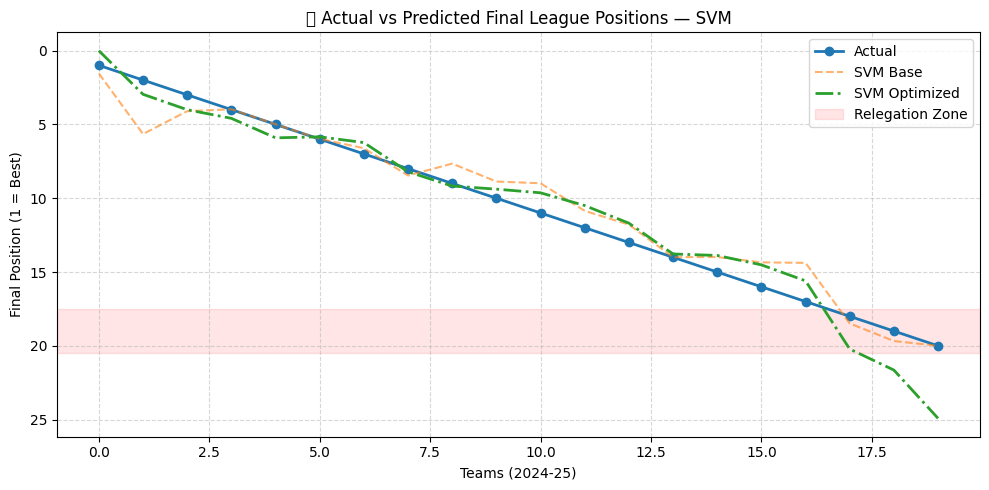

In [26]:
# 📉 Visualize actual final league positions vs. predictions from both base and optimized SVM models
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", marker='o', linewidth=2)
plt.plot(y_pred_test, label="SVM Base", linestyle='--', alpha=0.6)
plt.plot(y_pred_best_svr, label="SVM Optimized", linestyle='-.', linewidth=2)
plt.axhspan(17.5, 20.5, color='red', alpha=0.1, label='Relegation Zone')
plt.title("⚽ Actual vs Predicted Final League Positions — SVM")
plt.xlabel("Teams (2024-25)")
plt.ylabel("Final Position (1 = Best)")
plt.gca().invert_yaxis()  # So 1st is at top
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Model Metrics Summary Table: Base vs Optimized SVM

In [27]:
# 📈 Compare base and optimized SVM models on core regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base SVM metrics
mae_base_test = mean_absolute_error(y_test, y_pred_test)
rmse_base_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_base_test = r2_score(y_test, y_pred_test)

# Optimized SVM metrics
mae_optimized_test = mean_absolute_error(y_test, y_pred_best_svr)
rmse_optimized_test = np.sqrt(mean_squared_error(y_test, y_pred_best_svr))
r2_optimized_test = r2_score(y_test, y_pred_best_svr)

# Summary display
print("\n🔍 Model Performance Summary:")
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
print(f"{'SVM Base':<20} {mae_base_test:<10.3f} {rmse_base_test:<10.3f} {r2_base_test:<10.4f}")
print(f"{'SVM Optimized':<20} {mae_optimized_test:<10.3f} {rmse_optimized_test:<10.3f} {r2_optimized_test:<10.4f}")



🔍 Model Performance Summary:
Model                MAE        RMSE       R²        
SVM Base             0.975      1.350      0.9452    
SVM Optimized        1.228      1.620      0.9211    


## Relegation-Sensitive Metrics and Diagnostic Summary

In [28]:
# 📌 Evaluate performance of optimized SVM on critical relegation-related metrics
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

# Extra metrics
mape_test = mean_absolute_percentage_error(y_test, y_pred_best_svr) * 100
evs_test = explained_variance_score(y_test, y_pred_best_svr)
errors_test = y_test - y_pred_best_svr

# 📈 General regression diagnostics
print("\n📊 Relegation-Sensitive Performance (Test Set)")
print("="*70)
print(f"Explained Variance Score:           {evs_test:.4f}")
print(f"MAPE (Mean Absolute % Error):       {mape_test:.2f}%")
print(f"Error Mean:                         {errors_test.mean():+.3f}")
print(f"Error Std:                          {errors_test.std():.3f}")

# 🎯 Tolerance accuracy for decision flexibility
print("\n📌 Accuracy Within Position Tolerance:")
for tol in [1, 2, 3, 5]:
    acc = (np.abs(errors_test) <= tol).sum() / len(errors_test) * 100
    print(f"  Within ±{tol} positions: {acc:.1f}%")

# 🚨 Specific analysis for relegation zone teams
relegation_mask = y_test >= 18
if np.any(relegation_mask):
    rel_mae = mean_absolute_error(y_test[relegation_mask], y_pred_best_svr[relegation_mask])
    rel_acc = (np.abs(y_test[relegation_mask] - y_pred_best_svr[relegation_mask]) <= 1).mean() * 100
    print("\n🚨 Relegation Zone Focus:")
    print(f"  MAE for Relegation Teams:         {rel_mae:.3f} positions")
    print(f"  Accuracy within ±1 position:      {rel_acc:.1f}%")
else:
    print("\n🚨 No relegation teams (positions 18–20) present in the test set.")



📊 Relegation-Sensitive Performance (Test Set)
Explained Variance Score:           0.9216
MAPE (Mean Absolute % Error):       17.52%
Error Mean:                         -0.135
Error Std:                          1.656

📌 Accuracy Within Position Tolerance:
  Within ±1 positions: 50.0%
  Within ±2 positions: 85.0%
  Within ±3 positions: 95.0%
  Within ±5 positions: 100.0%

🚨 Relegation Zone Focus:
  MAE for Relegation Teams:         3.257 positions
  Accuracy within ±1 position:      0.0%


## Relegation-Focused Visual Diagnostics — Optimized SVM


/tmp/ipython-input-1879443214.py:39: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1879443214.py:39: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


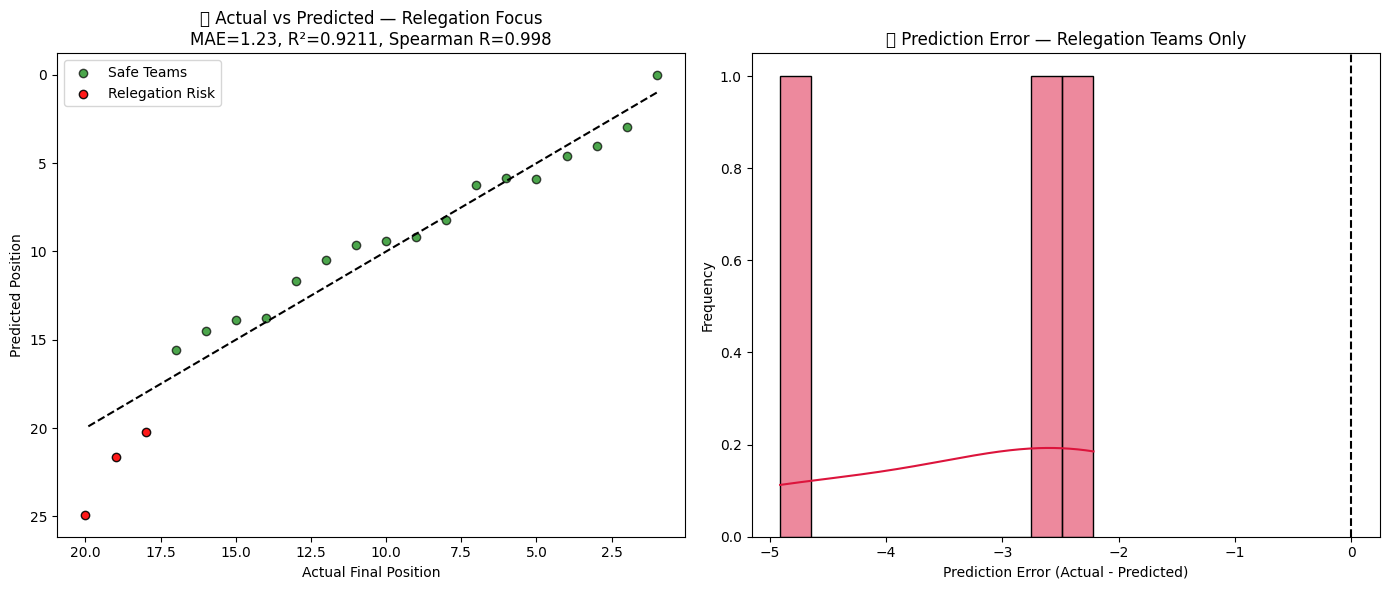

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr

# 📊 Compute predictions and errors
y_pred_train_svr = best_svr_model.predict(X_train)
errors_train = y_train - y_pred_train_svr
errors_test = y_test - y_pred_best_svr

# 📉 Spearman correlation for ranking relevance
rank_corr = spearmanr(y_test, y_pred_best_svr).correlation

# 📍 Identify relegation teams (actual or predicted)
relegation_zone = (y_test >= 18) | (y_pred_best_svr >= 18)

# 🎨 Create visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

## 🔵 Actual vs Predicted (Highlight Relegation Zone)
axes[0].scatter(y_test[~relegation_zone], y_pred_best_svr[~relegation_zone],
                color='green', label='Safe Teams', edgecolors='k', alpha=0.7)
axes[0].scatter(y_test[relegation_zone], y_pred_best_svr[relegation_zone],
                color='red', label='Relegation Risk', edgecolors='k', alpha=0.9)
axes[0].plot([1, 20], [1, 20], 'k--', lw=1.5)
axes[0].set_title(f"🔍 Actual vs Predicted — Relegation Focus\nMAE={mean_absolute_error(y_test, y_pred_best_svr):.2f}, R²={r2_score(y_test, y_pred_best_svr):.4f}, Spearman R={rank_corr:.3f}")
axes[0].set_xlabel("Actual Final Position")
axes[0].set_ylabel("Predicted Position")
axes[0].invert_xaxis(); axes[0].invert_yaxis()
axes[0].legend()

## 📊 Error Distribution on Relegation Teams
sns.histplot(errors_test[relegation_zone], bins=10, kde=True, ax=axes[1], color='crimson')
axes[1].axvline(0, color='black', linestyle='--')
axes[1].set_title("📉 Prediction Error — Relegation Teams Only")
axes[1].set_xlabel("Prediction Error (Actual - Predicted)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


## Categorical Evaluation Focused on Relegation Risk

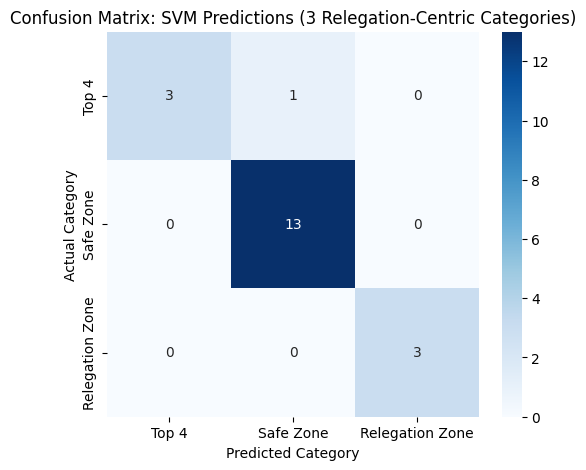

Classification Report for SVM (3 Relegation-Centric Categories):
                  precision    recall  f1-score   support

          Top 4       1.00      1.00      1.00         3
      Safe Zone       0.93      1.00      0.96        13
Relegation Zone       1.00      0.75      0.86         4

       accuracy                           0.95        20
      macro avg       0.98      0.92      0.94        20
   weighted avg       0.95      0.95      0.95        20


Category-Level Accuracy:
Top 4 Accuracy: 0.75
Safe Zone Accuracy: 1.00
Relegation Zone Accuracy: 1.00


In [35]:
# Import evaluation metrics and plotting libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a function to categorize into 3 levels
def categorize_3_levels(pos):
    if pos <= 4:
        return 'Top 4'
    elif pos >= 18:
        return 'Relegation Zone'
    else:
        return 'Safe Zone'

# Apply categorization to actual and predicted values using y_test and y_pred_best_svr
y_actual_cat_3 = [categorize_3_levels(int(pos)) for pos in y_test]                # true labels from actual positions
y_pred_cat_3   = [categorize_3_levels(int(round(pos))) for pos in y_pred_best_svr] # predicted labels from optimized SVR

# Define category labels for the 3 levels (in a meaningful order for plotting/reporting)
category_labels_3 = ['Top 4', 'Safe Zone', 'Relegation Zone']

# 1. Confusion Matrix: True vs Predicted categories (relegation-focused, 3 levels)
cm_3 = confusion_matrix(y_actual_cat_3, y_pred_cat_3, labels=category_labels_3)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_labels_3, yticklabels=category_labels_3)
plt.title('Confusion Matrix: SVM Predictions (3 Relegation-Centric Categories)')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()

# 2. Classification Report: Precision, Recall, F1 by category (3 levels)
report_3 = classification_report(y_actual_cat_3, y_pred_cat_3, target_names=category_labels_3)
print("Classification Report for SVM (3 Relegation-Centric Categories):\n", report_3)

# 3. Category-Level Accuracy: Accuracy for each relegation-related category
class_counts_3 = cm_3.sum(axis=1) # Sum of actual occurrences for each category
print("\nCategory-Level Accuracy:")
for idx, category in enumerate(category_labels_3):
    # Avoid division by zero if a category is missing in the test set's actual labels
    accuracy = cm_3[idx, idx] / class_counts_3[idx] if class_counts_3[idx] > 0 else 0
    print(f"{category} Accuracy: {accuracy:.2f}")

## ROC-AUC Analysis for SVM Classifier on League Position Categories


/tmp/ipython-input-1093930677.py:73: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


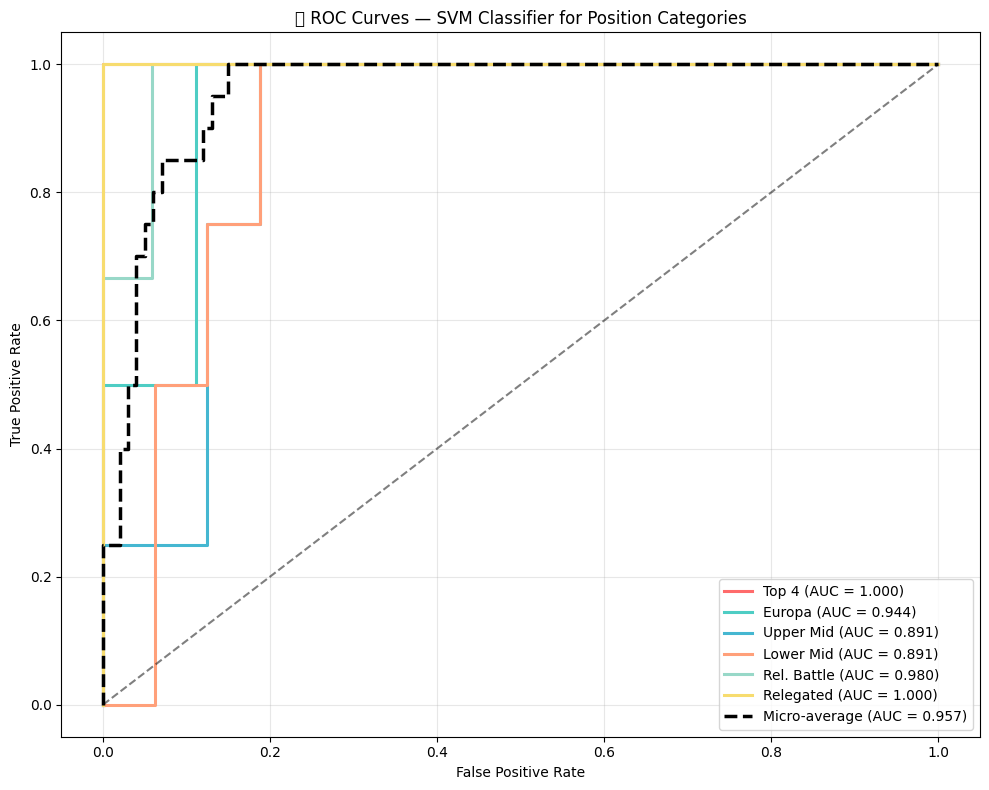

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Convert final league positions into category codes (0-5)
def position_to_category_code(pos):
    """Convert numeric rank into a category label."""
    if pos <= 4:
        return 0       # Top 4
    elif pos <= 6:
        return 1      # Europa
    elif pos <= 10:
        return 2     # Upper Mid-table
    elif pos <= 14:
        return 3     # Lower Mid-table
    elif pos <= 17:
        return 4     # Relegation Battle
    else:
        return 5               # Relegated

# Re-assign X_train and X_test from the original split (from cell _euOpUfcS-d_)
X_train = train_seasons[available_features].copy()
X_test = test_season[available_features].copy()

y_train_full = train_seasons['Final_Position']
y_test_full  = test_season['Final_Position']

y_train_cat = np.array([position_to_category_code(pos) for pos in y_train_full])
y_test_cat  = np.array([position_to_category_code(pos) for pos in y_test_full])

# Step 2: Train SVM classifier with probability support
svm_clf_pipeline = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, probability=True, random_state=42)
)
svm_clf_pipeline.fit(X_train, y_train_cat)
y_proba = svm_clf_pipeline.predict_proba(X_test)

# Step 3: Binarize true labels for ROC computation
n_classes = 6
y_test_bin = label_binarize(y_test_cat, classes=range(n_classes))

# Step 4: Compute ROC curve and AUC per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Step 5: Plot ROC Curves
plt.figure(figsize=(10, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
labels = ['Top 4', 'Europa', 'Upper Mid', 'Lower Mid', 'Rel. Battle', 'Relegated']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], lw=2.2, label=f'{labels[i]} (AUC = {roc_auc[i]:.3f})', color=color)

# Micro-average curve
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', lw=2.5, color='black', label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('🏁 ROC Curves — SVM Classifier for Position Categories')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Defining Relegation Target and Train/Test Split

---




In [ ]:
# ✅ Create binary target: 1 if team finishes 18th or lower (relegated), else 0
df_agg['Is_Relegated'] = (df_agg['Final_Position'] >= 18).astype(int)

# ✅ Split data by season
train_df = df_agg[df_agg['Season'] != '2024-25']
test_df  = df_agg[df_agg['Season'] == '2024-25']

# 🎯 Define classification target
y_train = train_df['Is_Relegated']
y_test  = test_df['Is_Relegated']

# 📊 Show target distribution
print("Training target distribution:")
print(y_train.value_counts(), "\n")
print("Test target distribution:")
print(y_test.value_counts())


Training target distribution:
Is_Relegated
0    408
1     72
Name: count, dtype: int64 

Test target distribution:
Is_Relegated
0    17
1     3
Name: count, dtype: int64


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Build a pipeline with StandardScaler and SVM (RBF kernel, C=1)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1, probability=True))
])

# Fit the SVM pipeline on the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=1, probability=True))])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on training and testing sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Compute classification metrics for the training set
train_accuracy  = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall    = recall_score(y_train, y_train_pred)
train_f1        = f1_score(y_train, y_train_pred)
train_cm        = confusion_matrix(y_train, y_train_pred)

# Compute classification metrics for the test set
test_accuracy   = accuracy_score(y_test, y_test_pred)
test_precision  = precision_score(y_test, y_test_pred)
test_recall     = recall_score(y_test, y_test_pred)
test_f1         = f1_score(y_test, y_test_pred)
test_cm         = confusion_matrix(y_test, y_test_pred)

# Display the results
print("Training Accuracy: {:.2f}".format(train_accuracy))
print("Training Precision: {:.2f}".format(train_precision))
print("Training Recall: {:.2f}".format(train_recall))
print("Training F1-Score: {:.2f}".format(train_f1))
print("Training Confusion Matrix:\n", train_cm)
print("\nTest Accuracy: {:.2f}".format(test_accuracy))
print("Test Precision: {:.2f}".format(test_precision))
print("Test Recall: {:.2f}".format(test_recall))
print("Test F1-Score: {:.2f}".format(test_f1))
print("Test Confusion Matrix:\n", test_cm)


Training Accuracy: 0.98
Training Precision: 0.97
Training Recall: 0.88
Training F1-Score: 0.92
Training Confusion Matrix:
 [[406   2]
 [  9  63]]

Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00
Test F1-Score: 1.00
Test Confusion Matrix:
 [[17  0]
 [ 0  3]]


## Predicting Relegation Probabilities


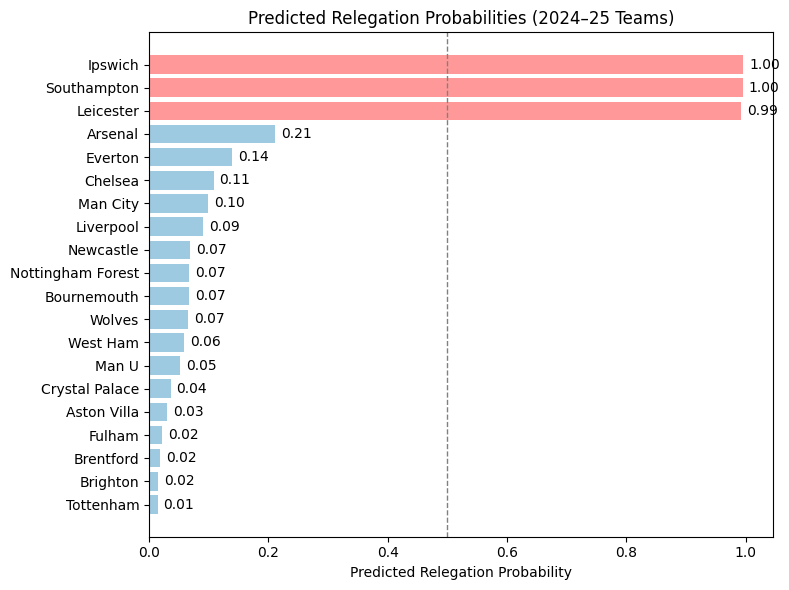

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Prepare training data (2023-24 final stats): GF = Goals For, GA = Goals Against
train_data = {
    'Team': ['Man City','Arsenal','Liverpool','Aston Villa','Tottenham','Chelsea',
             'Newcastle','Man U','West Ham','Crystal Palace',
             'Brighton','Bournemouth','Fulham','Wolves','Everton','Brentford','Forest','Luton','Burnley','Sheff Utd'],
    'GF':   [96,        91,        86,        76,           74,       77,
             85,        57,       60,         57,
             55,        54,         55,        50,      40,         56,        49,      52,     41,        35],
    'GA':   [34,         29,        41,        61,           61,        63,
             62,        58,       74,         58,
             62,        67,         61,        65,      51,         65,        67,      85,     78,       104],
    'Relegated': [0,    0,         0,         0,            0,        0,
                  0,        0,        0,         0,
                  0,        0,         0,        0,       0,         0,         0,        1,       1,        1]
}
train_df = pd.DataFrame(train_data)

# Prepare test data (2024-25 final stats)
test_data = {
    'Team': ['Liverpool','Arsenal','Man City','Chelsea','Newcastle',
             'Aston Villa','Nottingham Forest','Brighton','Bournemouth',
             'Brentford','Fulham','Crystal Palace','Everton','West Ham',
             'Man U','Wolves','Tottenham','Leicester','Ipswich','Southampton'],
    'GF':   [86,         69,       72,        64,        68,
             58,         58,        66,        58,
             66,        54,        51,        42,       46,
             44,         54,       64,        33,       36,       26],
    'GA':   [41,         34,       44,        43,        47,
             51,         46,        59,        46,
             57,        54,        51,        44,       62,
             54,         69,       65,        80,       82,       86],
    'Relegated': [0,     0,         0,         0,         0,
                 0,         0,         0,        0,
                 0,        0,         0,         0,       0,
                 0,         0,        0,         1,        1,        1]
}
test_df = pd.DataFrame(test_data)

# Feature matrices
X_train = train_df[['GF','GA']].values
y_train = train_df['Relegated'].values
X_test  = test_df[['GF','GA']].values
y_test  = test_df['Relegated'].values

# Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train SVM classifier with probability estimates enabled
svc = SVC(kernel='rbf', probability=True, random_state=0)
svc.fit(X_train_scaled, y_train)

# Compute predicted probabilities of relegation on test set
probs = svc.predict_proba(X_test_scaled)[:,1]
test_df['Prob_Relegation'] = probs

# Sort teams by predicted relegation probability
test_df.sort_values('Prob_Relegation', ascending=True, inplace=True)
teams = test_df['Team']
probas = test_df['Prob_Relegation']
actual = test_df['Relegated']

# Plot a horizontal bar chart
plt.figure(figsize=(8,6))
colors = ['#ff9999' if rel==1 else '#9ecae1' for rel in actual]
plt.barh(teams, probas, color=colors)
plt.axvline(0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Predicted Relegation Probability')
plt.title('Predicted Relegation Probabilities (2024–25 Teams)')
# Annotate probability values
for i, v in enumerate(probas):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()


## 🔍 Feature Importance via Permutation





Accuracy:  1.000
Precision: 1.000
Recall:    1.000
F1 Score:  1.000


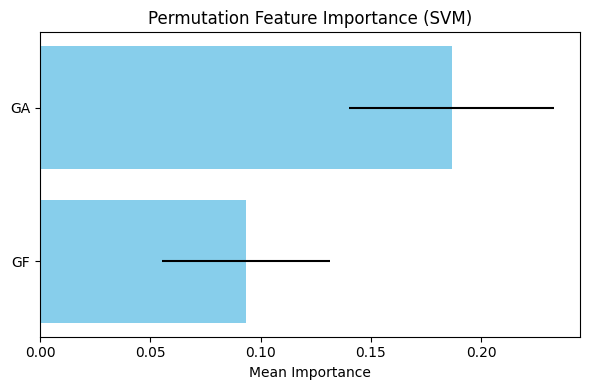

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# ✅ Features disponibles
features = ['GF', 'GA']

# 🎯 Features et cibles
X_train = train_df[features]
y_train = train_df['Relegated']
X_test  = test_df[features]
y_test  = test_df['Relegated']

# 🔄 Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 🧠 Entraînement SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# 🔍 Prédictions
y_pred = svm_model.predict(X_test_scaled)

# 📊 Évaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

# 🔍 Importance des variables via permutation
perm_result = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=30, random_state=42)
importances = perm_result.importances_mean
std = perm_result.importances_std
indices = np.argsort(importances)

# 📈 Visualisation
plt.figure(figsize=(6, 4))
plt.barh(range(len(indices)), importances[indices], xerr=std[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Mean Importance")
plt.title("Permutation Feature Importance (SVM)")
plt.tight_layout()
plt.show()


## Risk Categorization from Relegation Probabilities





In [ ]:
# Define risk thresholds
def risk_category(prob):
    if prob >= 0.6:
        return 'High Risk'
    elif prob >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

# Apply to each team
test_df['Risk_Level'] = test_df['Prob_Relegation'].apply(risk_category)

# Display sorted table with risk labels
display(test_df[['Team', 'Prob_Relegation', 'Risk_Level']].sort_values('Prob_Relegation', ascending=False))


,Team,Prob_Relegation,Risk_Level
18,Ipswich,0.995961,High Risk
19,Southampton,0.995134,High Risk
17,Leicester,0.992060,High Risk
1,Arsenal,0.211118,Low Risk
12,Everton,0.139270,Low Risk
3,Chelsea,0.108299,Low Risk
2,Man City,0.098441,Low Risk
0,Liverpool,0.090514,Low Risk
4,Newcastle,0.068782,Low Risk
8,Bournemouth,0.067220,Low Risk


## Visualization of Risk Distribution








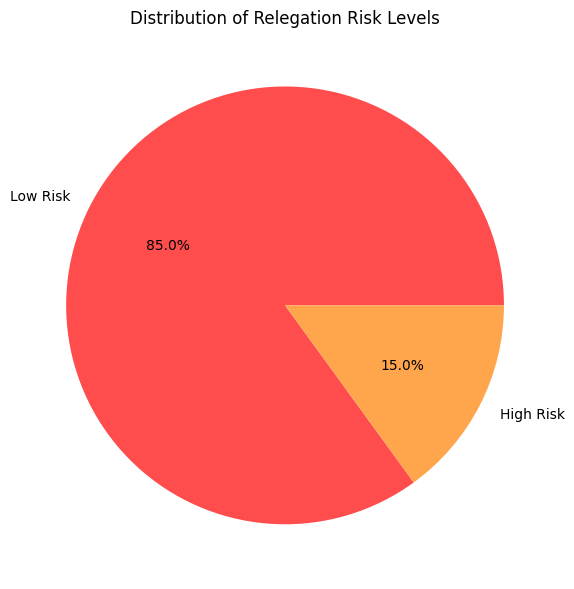

In [ ]:
# Count of teams by risk level
risk_counts = test_df['Risk_Level'].value_counts()

# Pie Chart
plt.figure(figsize=(6,6))
risk_counts.plot.pie(autopct='%1.1f%%', colors=['#ff4d4d', '#ffa64d', '#5dade2'])
plt.title("Distribution of Relegation Risk Levels")
plt.ylabel("")
plt.tight_layout()
plt.show()
